In [17]:
# Parameter setting

In [109]:
# data source
data_file = '/Users/jiangyi.wang/Desktop/Desktop - LAZ-SG-L-M-1109/Account Takeover/login v1.1/ato feature/ato_login_sample_feature_v0_1655779490321.txt'

# define venture, entrance (all entrance)
venture = 'ID'

# the whole dataset includes:
# 1155 black samples; 31718 white samples; (32873 in total)
# define training, testing dataset: (80%, 20% respectively)
# training: 26298 samples
# test: 6575 samples

# define whether to display feature importance, shap or PR curve on test data
is_grid_search, is_feature_importance, is_shap, is_plot_pr = True, True, True, True
# define whether to skip some sections, False means do not run that part
is_save_model, is_plot_interactive_pr, is_plot_thrhld_bin, is_comparision_w_old_model = False, True, True, True

# model feature list
features_to_use = ['no_unique_umid_14d',
                  'no_unique_ip2_14d',
                  'no_unique_ipisp_14d',
                  'id_new_umid_14d',
                  'id_new_ip2_14d',
                  'id_new_ipisp_14d',
                  'id_umid_same_seller_14d',
                  'id_ip2_same_seller_14d',
                  'avg_price_per_order_14d',
                  'std_price_per_order_14d',
                  'avg_discount_per_order_14d',
                  'std_discount_per_order_14d',
                  'avg_shpfee_per_order_14d',
                  'std_shpfee_per_order_14d',
                  'no_acct_umid_14d']


byr_idx_cols = ['label', 'buyer_id']

# feature list that needs to impute
features_to_impute = ['no_unique_umid_14d',
                  'no_unique_ip2_14d',
                  'no_unique_ipisp_14d',
                  'id_new_umid_14d',
                  'id_new_ip2_14d',
                  'id_new_ipisp_14d',
                  'id_umid_same_seller_14d',
                  'id_ip2_same_seller_14d',
                  'avg_price_per_order_14d',
                  'std_price_per_order_14d',
                  'avg_discount_per_order_14d',
                  'std_discount_per_order_14d',
                  'avg_shpfee_per_order_14d',
                  'std_shpfee_per_order_14d',
                  'no_acct_umid_14d']

model_list = ['rf', 'xgb']


# params of model
rf_default_param = {'bootstrap': True, 'oob_score': True, 'max_depth':10, 'n_estimators': 120, 'criterion':'gini',
             'n_jobs': -1, 'random_state': 0
               , 'class_weight': 'balanced'
            }
rf_param_grid = {
            'max_depth': [2, 8, 16],
            'n_estimators': [64, 128, 256],
            'bootstrap': [True], 
            'oob_score': [True], 
            'criterion':['gini'],
            'random_state': [0], 
            'class_weight': ['balanced'],
            'random_state': [0]
            }    

xgb_default_param = {'verbosity':0, 'n_jobs': -1, 'random_state':0}
xgb_param_grid = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5],
            'verbosity':[0],
            'use_label_encoder':[False],
            'random_state': [0]
            }              

model_params = {'rf': [rf_default_param, rf_param_grid],
                'xgb': [xgb_default_param, xgb_param_grid]
               }

# seed for generating the training / testing set
random_state = 42
test_size = 0.2

In [111]:
# best parameter
best_estimator_rf =  {
        'bootstrap' : [True],
        'class_weight' : ['balanced'],
        'criterion' : ['gini'],
        'max_depth' : [8],
        'n_estimators' : [256],
        'oob_score' : [True],
        'random_state' : [0]
    }

best_estimator_xgb =  {
        'colsample_bytree' : [0.6],
        'gamma' : [1.5],
        'max_depth' : [3],
        'min_child_weight' : [1],
        'random_state' : [0],
        'subsample' : [1.0],
        'use_label_encoder' : [False],
        'verbosity' : [0]
    }


model_params_best = {'rf': [rf_default_param, best_estimator_rf],
                'xgb': [xgb_default_param, best_estimator_xgb]
               }



In [19]:
# Import packages and define functions 

In [6]:
%pip install xgboost
%pip install shap

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import plotly.express as px

import json
import numpy as np
import pandas as pd
from datetime import datetime, timezone, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, precision_recall_curve, f1_score, roc_auc_score
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
import shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
## Functions for data size reducing and plotting

In [20]:
# define function to reduce data size
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df




# define function to plot PR curve
def plot_pr(y, pred):
    # based on different thresholds
    precision, recall, thresholds = precision_recall_curve(y, pred)

    f1_scores = []
    for i in range(len(thresholds)):
        f1_scores.append(2*recall[i]*precision[i]/(recall[i]+precision[i]))
    
    # select the best model according to the f1-score
    ix = np.argmax(f1_scores)
#     print('Best threshold: ', thresholds[ix])
#     print('Best F1-Score: ', np.max(f1_scores))

    fig, ax = plt.subplots()
    ax.plot(recall, precision)
    ax.scatter(recall[ix], precision[ix], marker='o', color='red', label='Best')

    # add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    plt.show()

    return thresholds[ix], precision, recall, thresholds, f1_scores


# display the distribution of features
# col2 represents the label;
# col1 reprensts the features
def display_kdeplot(df, col1, col2, is_cat):
    df[col1] = df[col1].astype(float)
    plt.figure(figsize = (15, 6))
    if is_cat:
        sns.countplot(data = df, x = col1, hue = col2)
    else:
        ax = plt.axes()
        sns.kdeplot(data = df[df[col2] == 0], x = col1, color = 'darkorange', label = 'Non-ATO')
        ax_bis = ax.twinx()
        sns.kdeplot(data = df[df[col2] == 1], x = col1, label = 'ATO')
        plt.title(col1)
        ax.legend(loc = 'upper left')
        ax_bis.legend(loc = 'upper right')
        # ax.set_xscale('log')
    plt.show
    
    print(df.groupby(col2)[col1].describe())
    


In [21]:
# Functions for model training and evaluation

In [79]:
def train_test_generation(df, features_to_use, byr_idx_cols, test_size, random_state = 42):
    feature_list = byr_idx_cols + features_to_use
    # only select the features we need
    df = df[feature_list].astype(float)
    
    y = df['label']
    
    df_train, df_test, y_train, y_test = train_test_split(df, y, test_size = test_size, random_state = random_state)
    
    X_train, X_test = df_train[features_to_use], df_test[features_to_use]
    
    return X_train, y_train, X_test, y_test, df_test

def display_model_metrics(y, y_pred):
    print('     F1 score:', f1_score(y, y_pred))
    print('     AUC:', roc_auc_score(y, y_pred))
    print('     Accuracy:', accuracy_score(y, y_pred))
    print('     Precision:', precision_score(y, y_pred))
    print('     Recall:', recall_score(y, y_pred))
    print("\tConfusion matrix：\n", confusion_matrix(y, y_pred))
    
# model grid search method
def model_grid_search(is_grid_search, clf_gs, param_grid, default_param, cv, x, y):
    if is_grid_search:
        grid_search = GridSearchCV(estimator = clf_gs,
                                  param_grid = param_grid,
                                  scoring = 'roc_auc',
                                  cv = 10,
                                  verbose = 3,
                                  n_jobs = 1
                                  )
        grid_search.fit(x, y)
        best_param = grid_search.best_params_
    else:
        best_param = default_param
        
    print('====> grid search parameters: \n{')
    [print(key,':',value) for key, value in param_grid.items()]
    print('}\n')
        
    print('====> best estimator: \n{')
    [print(key,':',value) for key, value in best_param.items()]
    print('}\n')
    
    return best_param


# model training process    
def model_train(mod, X_train, y_train, X_test, y_test, 
                threshold, features_to_use,
                is_feature_importance, is_shap, is_plot_pr):
    
    mod.fit(X_train, y_train)
    
    # model prediction on training set
    y_train_preds = mod.predict(X_train)
    y_train_preds_prob = mod.predict_proba(X_train)
    train_preds = [1 if y_train_preds_prob[i][1] > threshold else 0 for i in range(len(y_train_preds_prob))]
    print("=============================================================")
    print(f'Train:')
    print('Label distribution:\n{}\n'.format(y_train.value_counts()))
    display_model_metrics(y_train, train_preds)
    
    # model prediction on testing set
    y_test_preds = mod.predict(X_test)
    y_test_preds_prob = mod.predict_proba(X_test)
    test_preds = [1 if y_test_preds_prob[i][1] > threshold else 0 for i in range(len(y_test_preds_prob))]
    print("\n=============================================================")
    print('Testing:')
    print('Label distribution:\n{}\n'.format(y_test.value_counts()))
    display_model_metrics(y_test, test_preds)
    
    output_list = [mod]

    
    # feature importance
    if is_feature_importance is True:
        print("=============================================================")
        print(pd.DataFrame({'feature': list(features_to_use),
               'importance': mod.feature_importances_}).\
                sort_values('importance', ascending = False))
    # shapley value
    if is_shap is True:
        print("=============================================================")
        print('SHAP explanation: \n')
        explainer = shap.TreeExplainer(mod)
        shap_values = explainer.shap_values(X_test)
        try: 
            shap.summary_plot(shap_values[1], X_test, max_display=30)
        except:
            shap.summary_plot(shap_values, X_test, max_display=30)
    # precision-recall curve
    if is_plot_pr is True:
        print("=============================================================")
        thres, precision, recall, thresholds, f1_scores = plot_pr(y_test, y_test_preds_prob[:, 1])
        output_list.append([thres, precision, recall, thresholds, f1_scores])
    
    output_list.append(y_test_preds_prob[:,1])
    
    return output_list


# main function
# main function to run model and display result reports
def run_model(df, features_to_use, byr_idx_cols, 
              model_name, model_param, threshold, 
              is_grid_search, is_feature_importance, is_shap, is_plot_pr, test_size, random_state):
    
    X_train, y_train, X_test, y_test, df_test = train_test_generation(df, features_to_use, byr_idx_cols,
                                                                test_size, random_state)
    
    
    # model training
    x, y = X_train, y_train

    # RF
    if model_name == 'rf':
        print('=============================================================')
        print('                    Random forest model                      ')
        print('=============================================================')
        
        # grid search
        clf_gs = RandomForestClassifier()
        best_param = model_grid_search(is_grid_search, clf_gs, model_param[1], model_param[0], 5, x, y)
        clf = RandomForestClassifier(**best_param)
        
    # xgboost
    elif model_name == 'xgb':
        print('=============================================================')
        print('                      Xgboost model                          ')
        print('=============================================================')
        # grid search
        clf_gs = xgb.XGBClassifier()   
        best_param = model_grid_search(is_grid_search, clf_gs, model_param[1], model_param[0], 5, x, y)
        clf = xgb.XGBClassifier(**best_param)   
        
                
    output_list = model_train(clf, X_train, y_train, X_test, y_test, threshold,
                                  features_to_use, is_feature_importance, is_shap, is_plot_pr,
                                 )

    return output_list

In [23]:
# Main Funciton:

In [24]:
# 1. Load data

In [34]:
df = pd.read_csv(data_file, delimiter = ',', dtype = str)
df['label'] = df['label'].astype(float)
df.head()

,buyer_id,label,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_umid_same_seller_14d,id_ip2_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_discount_per_order_14d,std_discount_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,no_acct_umid_14d
0,10086597,0.0,1,5,2,0,0,0,0,0,\N,\N,\N,\N,\N,\N,1
1,10103494,0.0,1,2,1,0,0,0,0,0,\N,\N,\N,\N,\N,\N,1
2,10129841,0.0,1,2,2,0,0,0,0,0,97088.66666666667,56758.67384716533,969.6666666666666,1371.315750981111,10833.333333333334,2592.7248643506746,1
3,10135616,0.0,1,2,1,0,0,0,0,0,\N,\N,\N,\N,\N,\N,1
4,1015908,0.0,1,7,2,0,0,0,0,0,41100.0,0.0,27800.0,0.0,8000.0,0.0,1


In [35]:
# 2.impute null values with 0
df = df.replace('\\N', 0)
df[features_to_impute] = df[features_to_impute].astype(float)
df.head()

,buyer_id,label,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_umid_same_seller_14d,id_ip2_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_discount_per_order_14d,std_discount_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,no_acct_umid_14d
0,10086597,0.0,1.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
1,10103494,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2,10129841,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,97088.666667,56758.673847,969.666667,1371.315751,10833.333333,2592.724864,1.0
3,10135616,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
4,1015908,0.0,1.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,41100.000000,0.000000,27800.000000,0.000000,8000.000000,0.000000,1.0


In [36]:
# Print the size of the dataset
print('Dataset Shape:', df.shape)
print('-------------------------------')
# Check if any columns contain null
print('Column with Nulls:')
print(df.isnull().sum()[df.isnull().sum() != 0])

Dataset Shape: (32873, 17)
-------------------------------
Column with Nulls:
Series([], dtype: int64)


In [37]:
# Calculate percent of black samples
bl_cnt = (df.label==1).astype(float).sum()
total = (df.label!=-1).astype(float).sum()
percent = round((bl_cnt / total)*100, 2)

print(bl_cnt, 'black samples out of a total of', total, 'samples.')
print('Black sample percent: ' +  str(percent) + '%')

1155.0 black samples out of a total of 32873.0 samples.
Black sample percent: 3.51%


In [38]:
df_fature = reduce_mem_usage(df)

Memory usage of dataframe is 4.26 MB
Memory usage after optimization is: 2.76 MB
Decreased by 35.2%


In [43]:
df_feature.label.value_counts()

0.0    31718
1.0     1155
Name: label, dtype: int64

In [76]:
df_feature

,buyer_id,label,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_umid_same_seller_14d,id_ip2_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_discount_per_order_14d,std_discount_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,no_acct_umid_14d
0,10086597,0.0,1.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
1,10103494,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2,10129841,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,97088.664062,56758.675781,969.666687,1371.315796,10833.333008,2592.724854,1.0
3,10135616,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
4,1015908,0.0,1.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,41100.000000,0.000000,27800.000000,0.000000,8000.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32868,410479560888,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,483883.343750,550242.750000,329146.000000,366839.562500,5082.333496,4497.794922,13.0
32869,410480115286,1.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
32870,410480181090,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,550578.125000,629666.312500,749021.875000,981465.687500,11277.777344,10389.928711,9.0
32871,410480289725,1.0,1.0,7.0,3.0,1.0,1.0,0.0,0.0,1.0,97974.398438,52774.816406,82137.203125,59615.625000,3360.000000,3091.019287,3.0


In [44]:
# Feature EDA

In [45]:
# check unique value count within every feature
pd.set_option('display.max_rows', 200)
df_feature[features_to_use].apply(pd.Series.nunique)

no_unique_umid_14d               9
no_unique_ip2_14d               13
no_unique_ipisp_14d              8
id_new_umid_14d                  2
id_new_ip2_14d                   2
id_new_ipisp_14d                 2
id_umid_same_seller_14d          2
id_ip2_same_seller_14d           2
avg_price_per_order_14d       4256
std_price_per_order_14d       3011
avg_discount_per_order_14d    4092
std_discount_per_order_14d    2987
avg_shpfee_per_order_14d      1820
std_shpfee_per_order_14d      1921
no_acct_umid_14d                80
dtype: int64

         count      mean       std  min  25%  50%  75%  max
label                                                      
0.0    31718.0  1.114099  0.416275  0.0  1.0  1.0  1.0  8.0
1.0     1155.0  1.093506  0.430530  0.0  1.0  1.0  1.0  5.0
------------------------------------------------------------------------
         count      mean       std  min  25%  50%  75%   max
label                                                       
0.0    31718.0  2.698625  1.393667  0.0  2.0  2.0  3.0  12.0
1.0     1155.0  2.665801  1.477444  0.0  2.0  2.0  4.0   9.0
------------------------------------------------------------------------
         count      mean       std  min  25%  50%  75%  max
label                                                      
0.0    31718.0  1.533577  0.735116  0.0  1.0  1.0  2.0  7.0
1.0     1155.0  1.627706  0.782119  0.0  1.0  2.0  2.0  5.0
------------------------------------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


         count      mean       std  min  25%  50%  75%  max
label                                                      
0.0    31718.0  0.014314  0.118782  0.0  0.0  0.0  0.0  1.0
1.0     1155.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
------------------------------------------------------------------------
         count      mean       std  min  25%  50%  75%  max
label                                                      
0.0    31718.0  0.075068  0.263505  0.0  0.0  0.0  0.0  1.0
1.0     1155.0  0.824242  0.380779  0.0  1.0  1.0  1.0  1.0
------------------------------------------------------------------------
         count      mean       std  min  25%  50%  75%  max
label                                                      
0.0    31718.0  0.025380  0.157279  0.0  0.0  0.0  0.0  1.0
1.0     1155.0  0.657143  0.474870  0.0  0.0  1.0  1.0  1.0
------------------------------------------------------------------------
         count      mean       std  min  25%  50%  75%  max
l

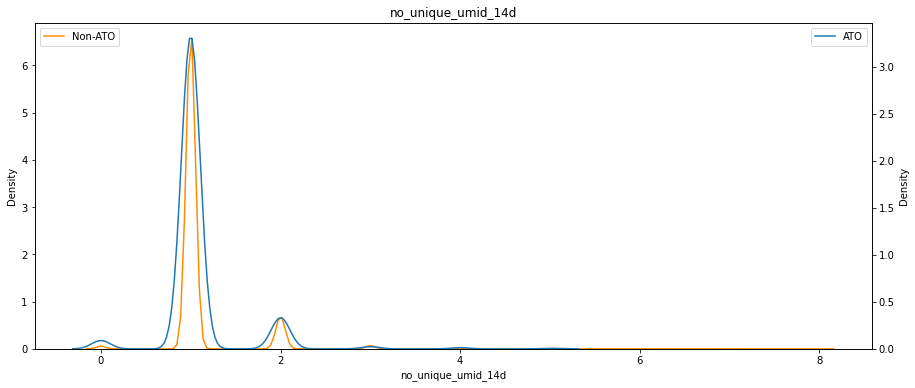

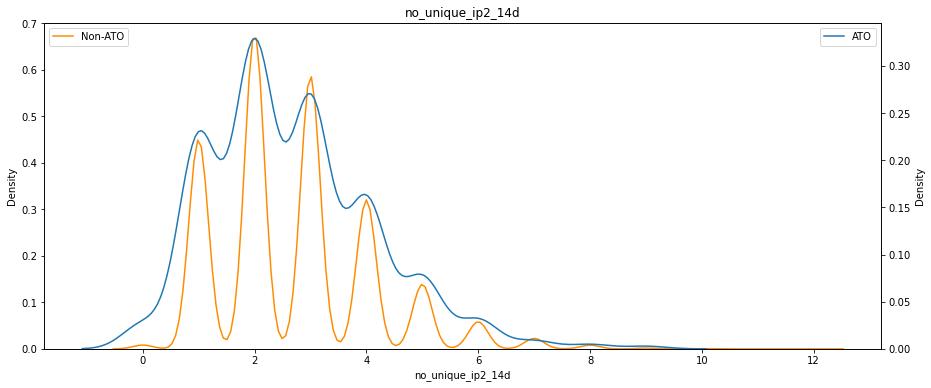

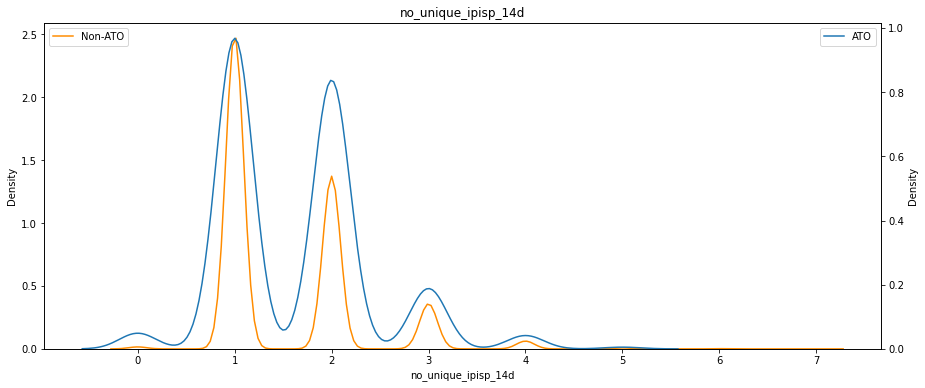

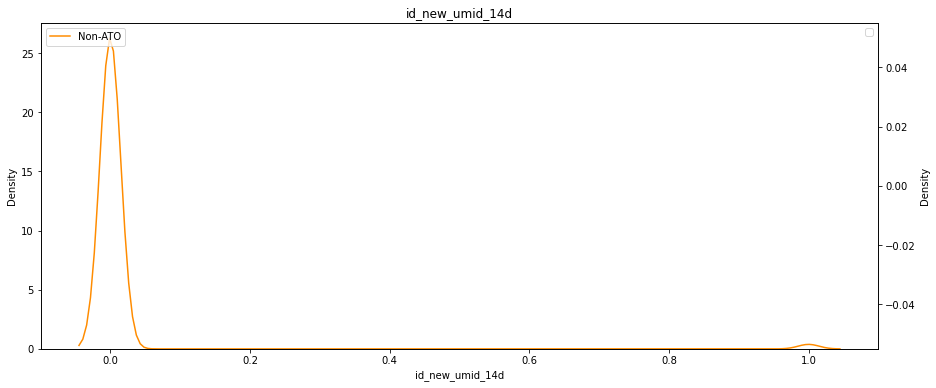

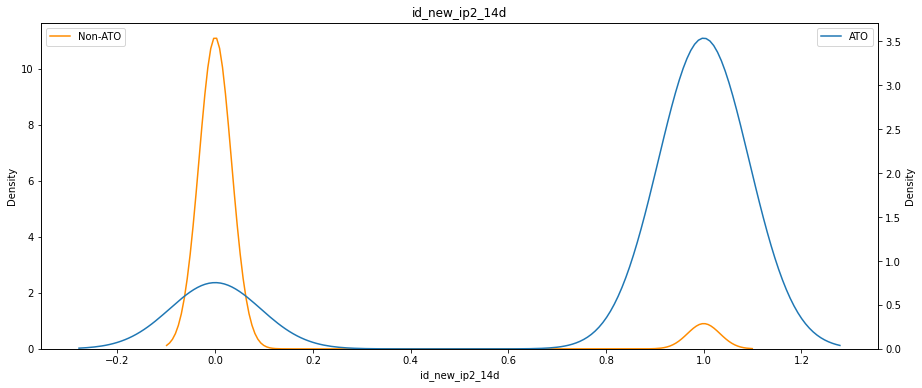

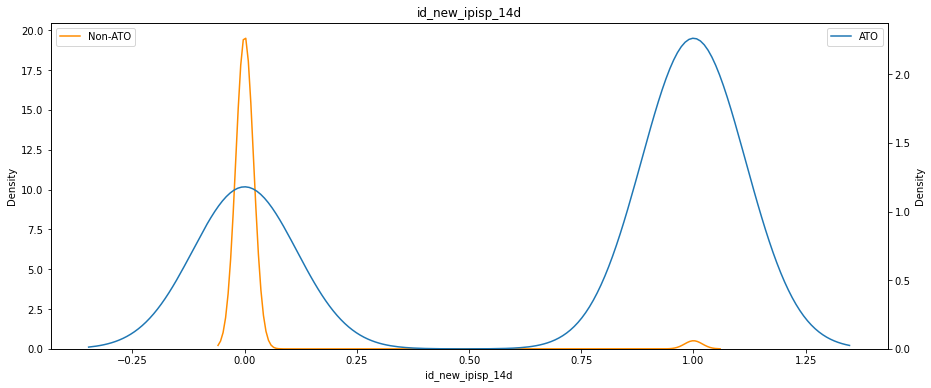

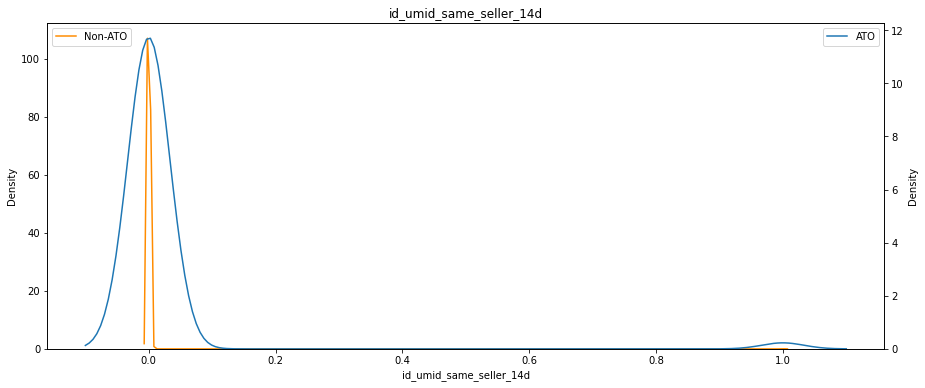

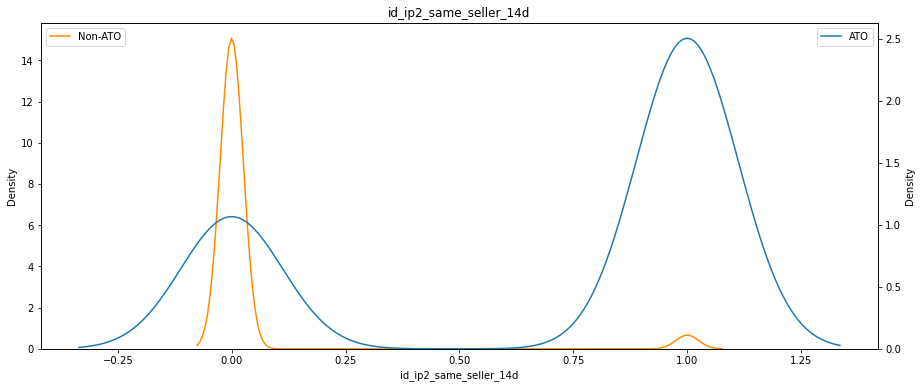

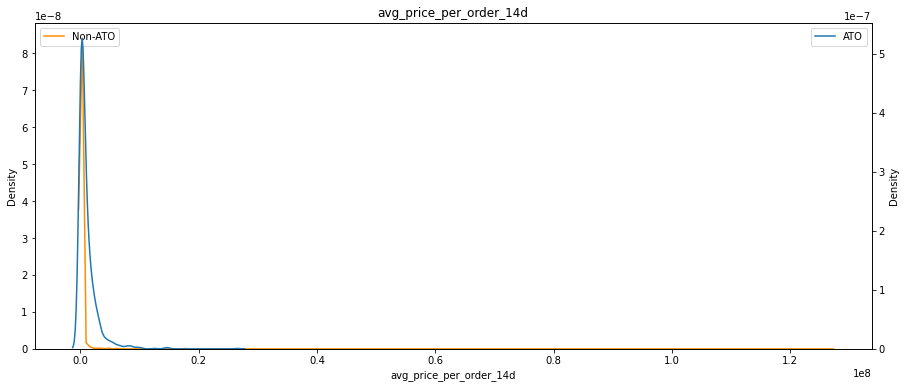

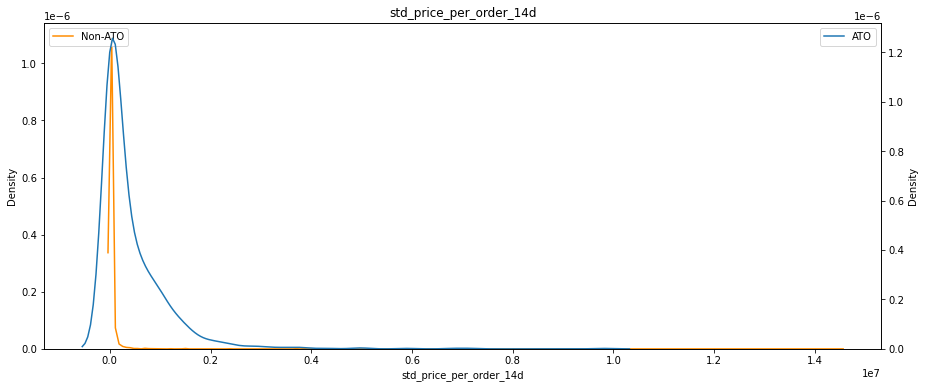

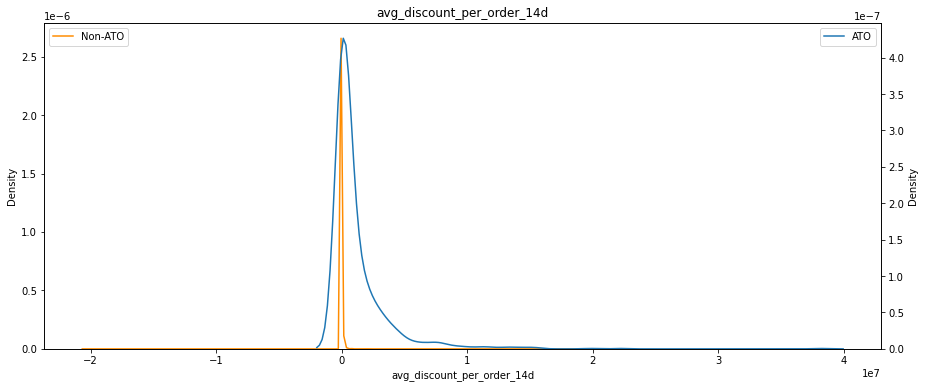

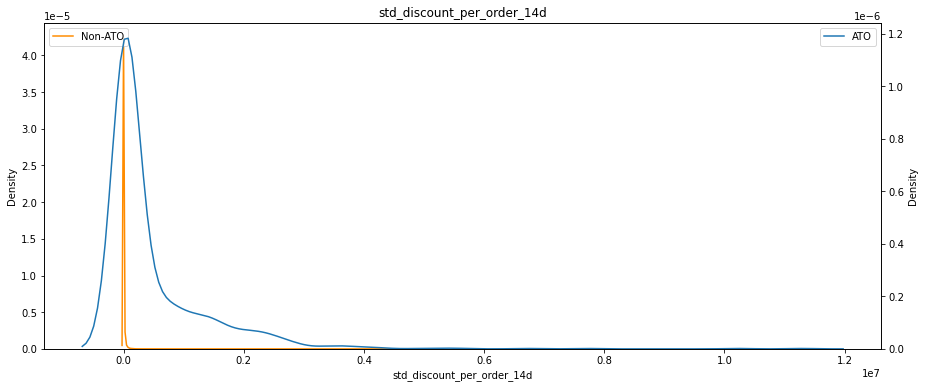

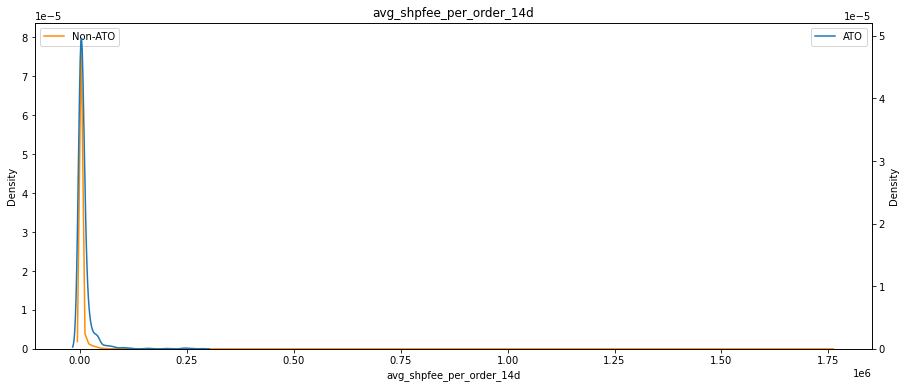

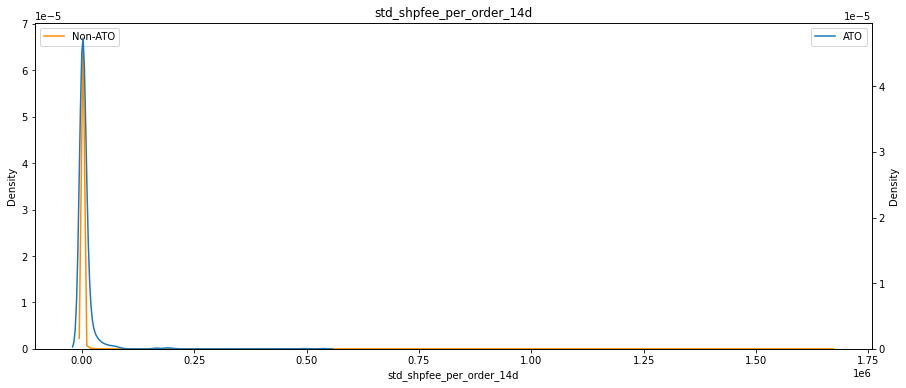

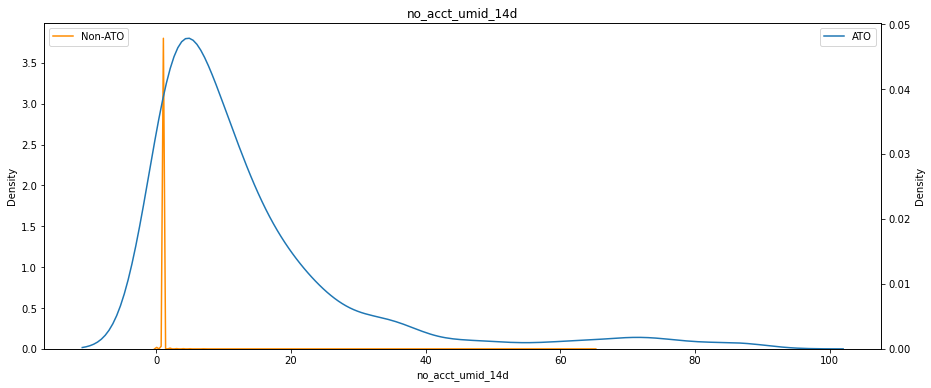

In [47]:
for i in range(len(features_to_use)):
    feature_name = features_to_use[i]
    display_kdeplot(df_feature, feature_name, 'label', False)
    print('------------------------------------------------------------------------')

In [ ]:
# Run models

                    Random forest model                      
Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=2, n_estimators=64, oob_score=True, random_state=0;, score=0.999 total time=   0.4s
[CV 2/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=2, n_estimators=64, oob_score=True, random_state=0;, score=1.000 total time=   0.4s
[CV 3/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=2, n_estimators=64, oob_score=True, random_state=0;, score=0.999 total time=   0.4s
[CV 4/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=2, n_estimators=64, oob_score=True, random_state=0;, score=0.999 total time=   0.3s
[CV 5/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=2, n_estimators=64, oob_score=True, random_state=0;, score=0.999 total time=   0.3s
[CV 6/10] END bootstrap=True, class_weight=balanced, criterion

[CV 10/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=8, n_estimators=128, oob_score=True, random_state=0;, score=1.000 total time=   0.9s
[CV 1/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=8, n_estimators=256, oob_score=True, random_state=0;, score=1.000 total time=   1.7s
[CV 2/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=8, n_estimators=256, oob_score=True, random_state=0;, score=1.000 total time=   1.7s
[CV 3/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=8, n_estimators=256, oob_score=True, random_state=0;, score=0.999 total time=   1.7s
[CV 4/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=8, n_estimators=256, oob_score=True, random_state=0;, score=1.000 total time=   1.7s
[CV 5/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=8, n_estimators=256, oob_score=True, random_state=0;, score=1.000 total time=   1.7s
[CV 6/10] END b

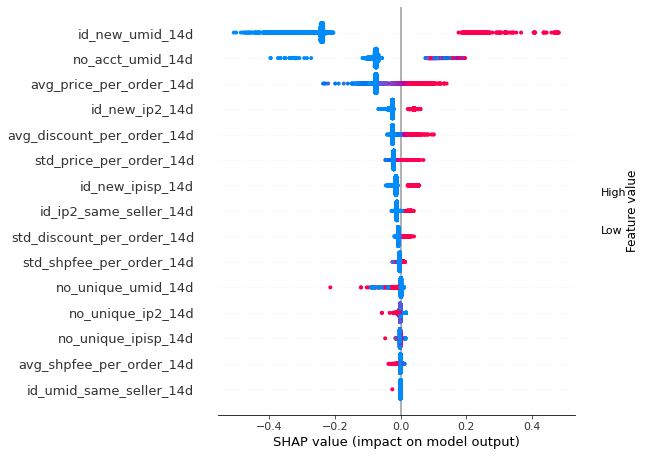

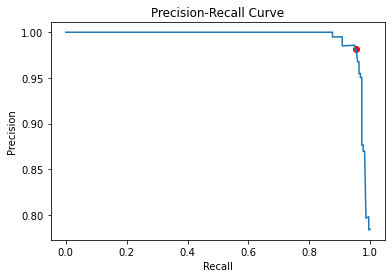

                      Xgboost model                          
Fitting 10 folds for each of 405 candidates, totalling 4050 fits
[CV 1/10] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 2/10] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.3s
[CV 3/10] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 4/10] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 5/10] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;,

[CV 5/10] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 6/10] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 7/10] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.5s
[CV 8/10] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 9/10] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 10/10] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, random_state=0

[CV 1/10] END colsample_bytree=0.6, gamma=0.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 2/10] END colsample_bytree=0.6, gamma=0.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 3/10] END colsample_bytree=0.6, gamma=0.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 4/10] END colsample_bytree=0.6, gamma=0.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 5/10] END colsample_bytree=0.6, gamma=0.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 6/10] END colsample_bytree=0.6, gamma=0.5, max_depth=4, min_child_weight=1, random_state=0,

[CV 7/10] END colsample_bytree=0.6, gamma=0.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.5s
[CV 8/10] END colsample_bytree=0.6, gamma=0.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 9/10] END colsample_bytree=0.6, gamma=0.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 10/10] END colsample_bytree=0.6, gamma=0.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 1/10] END colsample_bytree=0.6, gamma=0.5, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 2/10] END colsample_bytree=0.6, gamma=0.5, max_depth=4, min_child_weight=5, random_state=0

[CV 3/10] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 4/10] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 5/10] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 6/10] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 7/10] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.7s
[CV 8/10] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, random_state=0,

[CV 9/10] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 10/10] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 1/10] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 2/10] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 3/10] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.0s
[CV 4/10] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, random_state=0

[CV 5/10] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 6/10] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 7/10] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.4s
[CV 8/10] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 9/10] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, random_state=0, subsample=

[CV 1/10] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 2/10] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 3/10] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 4/10] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 5/10] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 6/10] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, random_state=0, subsample=1

[CV 7/10] END colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.5s
[CV 8/10] END colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 9/10] END colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 10/10] END colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 1/10] END colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 2/10] END colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1, random_state=0, subsample=

[CV 3/10] END colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 4/10] END colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 5/10] END colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 6/10] END colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 7/10] END colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.5s
[CV 8/10] END colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=5, random_state=0, subsample=1

[CV 9/10] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 1/10] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 2/10] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 3/10] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 4/10] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, random_state=0, subsample=

[CV 5/10] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 6/10] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 7/10] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.6s
[CV 8/10] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 9/10] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, random_state=0, subsample=

[CV 1/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 2/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 3/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 4/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 5/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 6/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0,

[CV 7/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.3s
[CV 8/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 9/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 10/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 1/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 2/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, random_state

[CV 3/10] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 4/10] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 5/10] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 6/10] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 7/10] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.4s
[CV 8/10] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=1, random_state=0,

[CV 9/10] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 10/10] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 1/10] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 2/10] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 3/10] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 4/10] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, random_sta

[CV 5/10] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 6/10] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 7/10] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 8/10] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 9/10] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, random_state=0

[CV 1/10] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 2/10] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 3/10] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 4/10] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 5/10] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 6/10] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, random_st

[CV 7/10] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.4s
[CV 8/10] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 9/10] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 10/10] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 1/10] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 2/10] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=1, random_state=0, subsample=

[CV 3/10] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 4/10] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 5/10] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 6/10] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 7/10] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.4s
[CV 8/10] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=10, random_state=0, subsa

[CV 9/10] END colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 10/10] END colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 1/10] END colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 2/10] END colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 3/10] END colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 4/10] END colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=1, random_state=0, subsample=

[CV 5/10] END colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 6/10] END colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 7/10] END colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.4s
[CV 8/10] END colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 9/10] END colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 10/10] END colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=10, random_state=0, subs

[CV 1/10] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 2/10] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 3/10] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 4/10] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 5/10] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 6/10] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=1, random_state=0, subsample=1

[CV 7/10] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.7s
[CV 8/10] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 9/10] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 1/10] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 2/10] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=10, random_state=0, subs

[CV 3/10] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.3s
[CV 4/10] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.3s
[CV 5/10] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.3s
[CV 6/10] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.3s
[CV 7/10] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.3s
[CV 8/10] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, random_state=0, subsample=1

[CV 9/10] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 10/10] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 1/10] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 2/10] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 3/10] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 4/10] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, random_state=0, subs

[CV 5/10] END colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   2.6s
[CV 6/10] END colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.4s
[CV 7/10] END colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.5s
[CV 8/10] END colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 9/10] END colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 10/10] END colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=1, random_state=0, subsample=

[CV 1/10] END colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 2/10] END colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 3/10] END colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 4/10] END colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 5/10] END colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 6/10] END colsample_bytree=0.6, gamma=5, max_depth=4, min_child_weight=10, random_state=0, subsa

[CV 7/10] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 8/10] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 9/10] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 10/10] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 1/10] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 2/10] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, random_state=0, subsample=

[CV 3/10] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 4/10] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 5/10] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 6/10] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 7/10] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.5s
[CV 8/10] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, random_state=0, subsa

[CV 9/10] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 10/10] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 1/10] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 2/10] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 3/10] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 4/10] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, random_state=0

[CV 5/10] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 6/10] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 7/10] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.5s
[CV 8/10] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 9/10] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 10/10] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, random_s

[CV 1/10] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 2/10] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 3/10] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.6s
[CV 4/10] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 5/10] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 6/10] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=5, random_state=0,

[CV 7/10] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.5s
[CV 8/10] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 9/10] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 1/10] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.4s
[CV 2/10] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, random_s

[CV 3/10] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   1.1s
[CV 4/10] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 5/10] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 6/10] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 7/10] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.7s
[CV 8/10] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, random_state=0,

[CV 9/10] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 1/10] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 2/10] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 3/10] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 4/10] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, random_s

[CV 5/10] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 6/10] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 7/10] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.6s
[CV 8/10] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 9/10] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   2.2s
[CV 10/10] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, random_state=0, subsample=

[CV 1/10] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 2/10] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 3/10] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 4/10] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 5/10] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 6/10] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, random_state=0, subsa

[CV 7/10] END colsample_bytree=0.8, gamma=1, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.6s
[CV 8/10] END colsample_bytree=0.8, gamma=1, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 9/10] END colsample_bytree=0.8, gamma=1, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 10/10] END colsample_bytree=0.8, gamma=1, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 1/10] END colsample_bytree=0.8, gamma=1, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 2/10] END colsample_bytree=0.8, gamma=1, max_depth=4, min_child_weight=5, random_state=0, subsample=

[CV 3/10] END colsample_bytree=0.8, gamma=1, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 4/10] END colsample_bytree=0.8, gamma=1, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 5/10] END colsample_bytree=0.8, gamma=1, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 6/10] END colsample_bytree=0.8, gamma=1, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 7/10] END colsample_bytree=0.8, gamma=1, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 8/10] END colsample_bytree=0.8, gamma=1, max_depth=4, min_child_weight=10, random_state=0, subsa

[CV 9/10] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 1/10] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 2/10] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 3/10] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 4/10] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, random_state=0, subsample=

[CV 5/10] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 6/10] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 7/10] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 8/10] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 9/10] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, random_state=0, subs

[CV 1/10] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 2/10] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 3/10] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 4/10] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 5/10] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 6/10] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, random_state=0,

[CV 7/10] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 8/10] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 9/10] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 10/10] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 1/10] END colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 2/10] END colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=1, random_sta

[CV 3/10] END colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 4/10] END colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 5/10] END colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 6/10] END colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 7/10] END colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.7s
[CV 8/10] END colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=5, random_state=0,

[CV 9/10] END colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 10/10] END colsample_bytree=0.8, gamma=1.5, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 1/10] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 2/10] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 3/10] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 4/10] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, random_state

[CV 5/10] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 6/10] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 7/10] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.8s
[CV 8/10] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 9/10] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 10/10] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, random_state=0

[CV 1/10] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 2/10] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 3/10] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 4/10] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 5/10] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 6/10] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=1, random_state=0, subsample=0

[CV 7/10] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   1.2s
[CV 8/10] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 9/10] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 1/10] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 2/10] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, random_state=0, subsample=

[CV 3/10] END colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 4/10] END colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 5/10] END colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 6/10] END colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 7/10] END colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 8/10] END colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=1, random_state=0, subsample=0

[CV 9/10] END colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 10/10] END colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 1/10] END colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 2/10] END colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 3/10] END colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 4/10] END colsample_bytree=0.8, gamma=2, max_depth=4, min_child_weight=5, random_state=0, subsample=

[CV 5/10] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 6/10] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 7/10] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.8s
[CV 8/10] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 9/10] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 10/10] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=1, random_state=0, subsample=

[CV 1/10] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 2/10] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 3/10] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 4/10] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 5/10] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 6/10] END colsample_bytree=0.8, gamma=2, max_depth=5, min_child_weight=5, random_state=0, subsample=1

[CV 7/10] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 8/10] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 9/10] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 1/10] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 2/10] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, random_state=0, subsample=

[CV 3/10] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 4/10] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 5/10] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 6/10] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 7/10] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.6s
[CV 8/10] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, random_state=0, subsample=1

[CV 9/10] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 10/10] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 1/10] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 2/10] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 3/10] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 4/10] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=1, random_state=0, subsample=

[CV 5/10] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 6/10] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 7/10] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.8s
[CV 8/10] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 9/10] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=5, random_state=0, subsample=

[CV 1/10] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.0s
[CV 2/10] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 3/10] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 4/10] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 5/10] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 6/10] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, random_state=0, subsample=0

[CV 7/10] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 8/10] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 9/10] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 10/10] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 1/10] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 2/10] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, random_state=0, subsampl

[CV 3/10] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 4/10] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 5/10] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 6/10] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 7/10] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.6s
[CV 8/10] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, random_state=0,

[CV 9/10] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 1/10] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 2/10] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 3/10] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 4/10] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, random_sta

[CV 5/10] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 6/10] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 7/10] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.8s
[CV 8/10] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 9/10] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.0s
[CV 10/10] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, random_state=0

[CV 1/10] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 2/10] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 3/10] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 4/10] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 5/10] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 6/10] END colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=10, random_st

[CV 7/10] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   1.1s
[CV 8/10] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.1s
[CV 9/10] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.3s
[CV 10/10] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.1s
[CV 1/10] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.1s
[CV 2/10] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, random_state=0

[CV 3/10] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 4/10] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 5/10] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 6/10] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 7/10] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.7s
[CV 8/10] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, random_st

[CV 9/10] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 10/10] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 1/10] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 2/10] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 3/10] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 4/10] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, random_state=0, subsample=

[CV 5/10] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 6/10] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 7/10] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.5s
[CV 8/10] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 9/10] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 10/10] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, random_state=0, subs

[CV 1/10] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 2/10] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 3/10] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 4/10] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 5/10] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 6/10] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=1, random_state=0, subsample=1

[CV 7/10] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.6s
[CV 8/10] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 9/10] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 10/10] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 1/10] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 2/10] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, random_state=0, subs

[CV 3/10] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.0s
[CV 4/10] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 5/10] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 6/10] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 7/10] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 8/10] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, random_state=0, subsample=1

[CV 9/10] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 1/10] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 2/10] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 3/10] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 4/10] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, random_state=0, subs

[CV 5/10] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 6/10] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 7/10] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.6s
[CV 8/10] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 9/10] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.5s
[CV 10/10] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0

[CV 1/10] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 2/10] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 3/10] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 4/10] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 5/10] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 6/10] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, random_st

[CV 7/10] END colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.6s
[CV 8/10] END colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 9/10] END colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 10/10] END colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 1/10] END colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 2/10] END colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=5, random_state=0

[CV 3/10] END colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 4/10] END colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 5/10] END colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 6/10] END colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 7/10] END colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.7s
[CV 8/10] END colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=10, random_st

[CV 9/10] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 1/10] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 2/10] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 3/10] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 4/10] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, random_state=0

[CV 5/10] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 6/10] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 7/10] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.7s
[CV 8/10] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 9/10] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 10/10] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, random_s

[CV 1/10] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 2/10] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 3/10] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 4/10] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 5/10] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 6/10] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=5, random_state=0, subsample=0

[CV 7/10] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.6s
[CV 8/10] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 9/10] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 10/10] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 1/10] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 2/10] END colsample_bytree=1.0, gamma=2, max_depth=3, min_child_weight=10, random_state=0, subs

[CV 3/10] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 4/10] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 5/10] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 6/10] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 7/10] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.7s
[CV 8/10] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=5, random_state=0, subsample=0

[CV 9/10] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 10/10] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=10, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 1/10] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 2/10] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 3/10] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 4/10] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=10, random_state=0, subs

[CV 5/10] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 6/10] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 7/10] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.7s
[CV 8/10] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 9/10] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 10/10] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=5, random_state=0, subsample=

[CV 1/10] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 2/10] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.0s
[CV 3/10] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.2s
[CV 4/10] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.0s
[CV 5/10] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 6/10] END colsample_bytree=1.0, gamma=2, max_depth=5, min_child_weight=10, random_state=0, subsa

[CV 7/10] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.7s
[CV 8/10] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 9/10] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 10/10] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 1/10] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.6s
[CV 2/10] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, random_state=0, subsample=

[CV 3/10] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 4/10] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 5/10] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 6/10] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 7/10] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.7s
[CV 8/10] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, random_state=0, subsa

[CV 9/10] END colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 10/10] END colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.6, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 1/10] END colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.1s
[CV 2/10] END colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 3/10] END colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 4/10] END colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=5, random_state=0, subsample=

[CV 5/10] END colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 6/10] END colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 7/10] END colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.8s
[CV 8/10] END colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 9/10] END colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 10/10] END colsample_bytree=1.0, gamma=5, max_depth=4, min_child_weight=10, random_state=0, subs

[CV 1/10] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.0s
[CV 2/10] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.4s
[CV 3/10] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.2s
[CV 4/10] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   1.0s
[CV 5/10] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, random_state=0, subsample=0.8, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.9s
[CV 6/10] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, random_state=0, subsample=0

[CV 7/10] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=0.999 total time=   0.6s
[CV 8/10] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 9/10] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
[CV 10/10] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.7s
====> grid search parameters: 
{
min_child_weight : [1, 5, 10]
gamma : [0.5, 1, 1.5, 2, 5]
subsample : [0.6, 0.8, 1.0]
colsample_bytree : [0.6, 0.8, 1.0]
max_depth : [3, 4, 5]
verbosity : [0]
use_label_encoder : [False]
random_state : [0]
}

====> best estimator: 
{
colsample_by

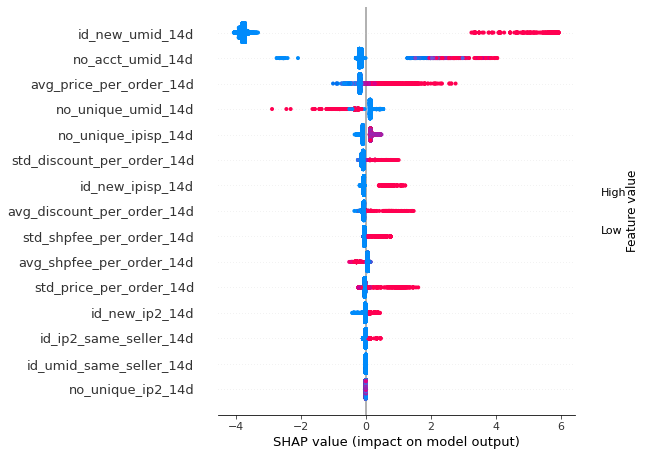

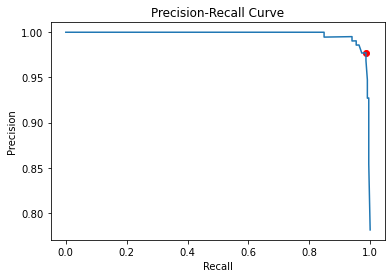

CPU times: user 4h 15min 58s, sys: 11min 52s, total: 4h 27min 50s
Wall time: 45min 46s


In [69]:
%%time 
res = {}
X_train, y_train, X_test, y_test, df_test = train_test_generation(df_feature, features_to_use, byr_idx_cols,
                                 test_size = 0.2, random_state = 42)
df_test['buyer_id'] = df_test['buyer_id'].astype(str)


for model in model_list:
    res_m = run_model(df_feature, features_to_use, byr_idx_cols,
                     model, model_params[model], 0.5, 
                     is_grid_search, is_feature_importance, is_shap, is_plot_pr, 0.2, 42)
    res[model] = res_m
    # res_m[-2] -> parameters for PR-curve (metric and corresponding threshold)
    # res_m[-1] -> probability prediction for testing sample
    df_test[model+'_pred'] = res_m[-1]

                    Random forest model                      
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=8, n_estimators=256, oob_score=True, random_state=0;, score=1.000 total time=   1.8s
[CV 2/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=8, n_estimators=256, oob_score=True, random_state=0;, score=1.000 total time=   1.7s
[CV 3/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=8, n_estimators=256, oob_score=True, random_state=0;, score=0.999 total time=   1.8s
[CV 4/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=8, n_estimators=256, oob_score=True, random_state=0;, score=1.000 total time=   1.7s
[CV 5/10] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=8, n_estimators=256, oob_score=True, random_state=0;, score=1.000 total time=   1.7s
[CV 6/10] END bootstrap=True, class_weight=balanced, crit

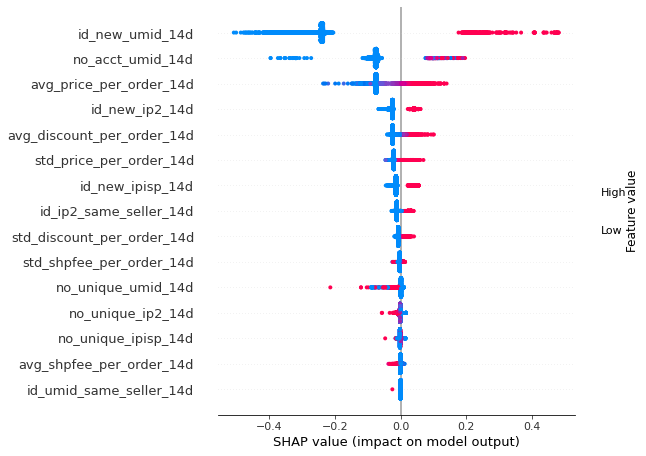

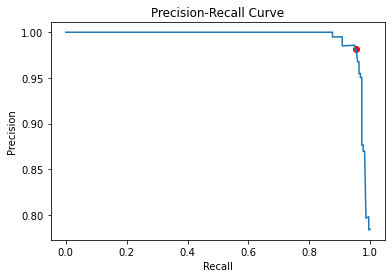

                      Xgboost model                          
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.3s
[CV 2/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.3s
[CV 3/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.3s
[CV 4/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, score=1.000 total time=   0.3s
[CV 5/10] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, random_state=0, subsample=1.0, use_label_encoder=False, verbosity=0;, sco

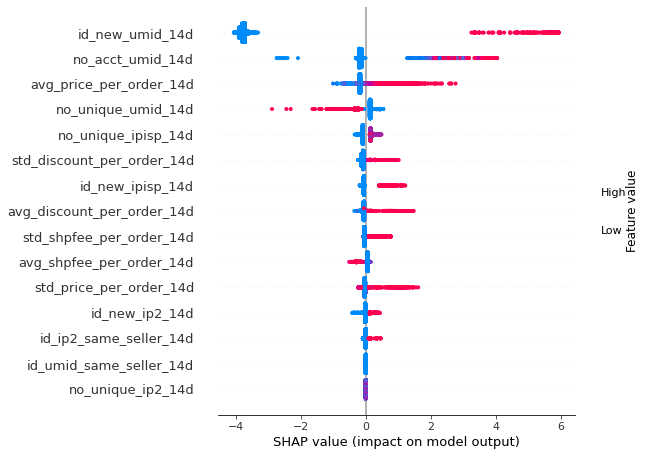

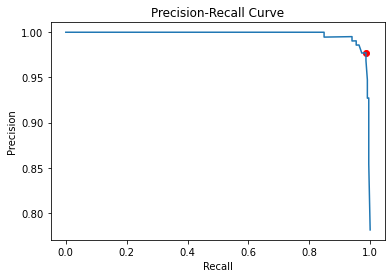

In [112]:
# Best model
X_train, y_train, X_test, y_test, df_test = train_test_generation(df_feature, features_to_use, byr_idx_cols,
                                 test_size = test_size, random_state = random_state)
df_test = df_test.astype(float)
df_test['buyer_id'] = df_test['buyer_id'].astype(str)


for model in model_list:
    res_m = run_model(df_feature, features_to_use, byr_idx_cols,
                     model, model_params_best[model], 0.5, 
                     is_grid_search, is_feature_importance, is_shap, is_plot_pr, test_size, random_state)
    res[model] = res_m
    # res_m[-2] -> parameters for PR-curve (metric and corresponding threshold)
    # res_m[-1] -> probability prediction for testing sample
    df_test[model+'_pred'] = res_m[-1]

In [127]:
df_test = df_test.astype(float)
df_test['buyer_id'] = df_test['buyer_id'].astype(str)

In [154]:
df_test['rf_pred_label'] = df_test['rf_pred'].apply(lambda x: 1 if x > 0.5 else 0)
df_test['xgb_pred_label'] = df_test['xgb_pred'].apply(lambda x: 1 if x > 0.5 else 0)


,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_umid_same_seller_14d,id_ip2_same_seller_14d,...,std_price_per_order_14d,avg_discount_per_order_14d,std_discount_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,no_acct_umid_14d,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
13638,0.0,400266009319.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.003673,0.000049,0,0
3710,0.0,400085583613.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.003407,0.000034,0,0
28154,0.0,410440932327.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.003673,0.000049,0,0
10217,0.0,400216113697.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.002383,0.000049,0,0
13885,0.0,400270119856.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.002538,0.000051,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11791,0.0,400240149259.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.002383,0.000049,0,0
10925,0.0,400227030101.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.002383,0.000049,0,0
21786,0.0,400369743288.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15013.0,0.0,49000.0,0.0,1.0,0.003325,0.000034,0,0
22545,0.0,400379550119.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.002383,0.000049,0,0


In [145]:
# analyse for xgb

FP = df_test[(df_test['label'] == 1) & (df_test['xgb_pred_label'] == 0)]
FP

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_umid_same_seller_14d,id_ip2_same_seller_14d,...,std_price_per_order_14d,avg_discount_per_order_14d,std_discount_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,no_acct_umid_14d,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
32801,1.0,410414889193.0,2.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.680659,0.380861,1,0
32292,1.0,400137282563.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.743458,0.210480,1,0
31816,1.0,13979815.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.874361,0.399097,1,0
31841,1.0,19347523.0,1.0,4.0,2.0,1.0,1.0,0.0,0.0,1.0,...,1344.5,0.0,0.0,1725.0,1725.0,1.0,0.418270,0.182474,0,0
32696,1.0,400380111938.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.655050,0.068808,1,0
32138,1.0,400078356312.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-150.0,0.0,0.0,0.0,1.0,0.776970,0.397642,1,0


In [148]:
FN = df_test[(df_test['label'] == 0) & (df_test['xgb_pred_label'] == 1)]
FN

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_umid_same_seller_14d,id_ip2_same_seller_14d,...,std_price_per_order_14d,avg_discount_per_order_14d,std_discount_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,no_acct_umid_14d,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
7545,0.0,400161255562.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.0,0.854396,0.507652,1,1
491,0.0,23724211.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,...,3.206978e+04,142978.828125,93762.484375,0.000000,0.000000,1.0,0.753229,0.854088,1,1
5532,0.0,400125096743.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.0,0.854396,0.507652,1,1
10191,0.0,400215741185.0,7.0,3.0,3.0,1.0,0.0,0.0,0.0,1.0,...,1.822557e+06,139642.859375,330962.968750,4579.285645,3628.569336,4.0,0.676134,0.786592,1,1
3492,0.0,400080456867.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,...,4.923429e+04,79095.140625,82192.250000,6920.285645,5218.217773,2.0,0.904462,0.982758,1,1


In [153]:
df_test[df_test['xgb_pred_label'] == 0].groupby('id_new_umid_14d').size()

id_new_umid_14d
0.0    6264
1.0      94
dtype: int64

In [162]:
# df_feature.groupby('id_umid_same_seller_14d').size()

df_test[(df_test['id_umid_same_seller_14d']==1) & (df_test['xgb_pred_label']==0)]

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_umid_same_seller_14d,id_ip2_same_seller_14d,...,std_price_per_order_14d,avg_discount_per_order_14d,std_discount_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,no_acct_umid_14d,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
8270,0.0,400175391725.0,2.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,...,2.734146e+04,80000.00,9.050967e+04,4878.333496,3109.598877,5.0,0.038677,0.000430,0,0
2588,0.0,400055580313.0,2.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.450037e+06,2872940.25,4.442558e+06,18407.142578,16224.213867,7.0,0.127800,0.003743,0,0


In [164]:
df_test.head(10)

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_umid_same_seller_14d,id_ip2_same_seller_14d,...,std_price_per_order_14d,avg_discount_per_order_14d,std_discount_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,no_acct_umid_14d,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
13638,0.0,400266009319.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.003673,0.000049,0,0
3710,0.0,400085583613.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.003407,0.000034,0,0
32800,1.0,410413185724.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.934427,0.831284,1,1
28154,0.0,410440932327.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.003673,0.000049,0,0
10217,0.0,400216113697.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.002383,0.000049,0,0
13885,0.0,400270119856.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.002538,0.000051,0,0
6291,0.0,400138797008.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.002991,0.000051,0,0
6847,0.0,400149198935.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.001939,0.000051,0,0
32134,1.0,400078227816.0,2.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,...,0.0,2450510.0,0.0,0.0,0.0,5.0,0.961889,0.985521,1,1
30513,0.0,410468370619.0,1.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.001952,0.000051,0,0
